# __Vanilla Autoencoder with PyTorch__

In [1]:
# For auto saving and applying changes to modified files.
%load_ext autoreload
%autoreload 2

In [2]:
# Prepare Packages
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import sampler
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as T

# Comment these if you're using ucsd datahub, otherwise uncomment.
# from utilities.utils import *

# Comment these if you're not using ucsd datahub, otherwise uncomment.
import sys
sys.path.append('..')
import utilities.utils as utils
import utilities.AE_utils as AE

In [3]:
# Prepare dataset
'''
    TRAIN_MNIST & TEST_MNIST are objects of type (or instances of) 
    `torchvision.datasets.MNIST`.
    
    Running `print(TRAIN_MNIST)` will print out all the information
    about the dataset: Number of datapoints, root location, etc.
    
    TRAIN_MNIST[i] is a tuple (xi, yi) where i is the ith
    datapoint, xi is a tensor, and yi is an integer label/class 
    of xi. Same concept applies to VAL_MNIST[i] & TEST_MNIST[i].
'''

# Declare necessary constants
USE_GPU = True
DTYPE = torch.float32
PATH = "../dataset"
    
transform = T.Compose(
    [
        T.Resize((28,28)),
        T.ToTensor()
    ]
)

TRAIN_MNIST = datasets.MNIST(
    root=PATH,
    train=True,
    download=True,
    transform=transform
)

VAL_MNIST = datasets.MNIST(
    root=PATH,
    train=True,
    download=True,
    transform=transform
)

TEST_MNIST = datasets.MNIST(
    root=PATH,
    train=False,
    download=True,
    transform=transform
)

# Use `num_workers = 6` for faster loading data
# and set `pin_memory = True`. The number 6
# for `num_workers` is obtained via running get_optimal_num_workers()
num_workers, pin_memory = 1, False
if num_workers == None:
    num_workers = utils.get_optimal_num_workers(TRAIN_MNIST, VERBOSE=False)
    pin_memory = True

# Specify if use gpu and multiprocessors for training.
if USE_GPU and torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    kwargs = {'num_workers': num_workers, 'pin_memory': pin_memory}
else:
    DEVICE = torch.device('cpu')
    kwargs = {}
    
# Prepare dataloaders
NUM_TRAIN = 50000

loader_TRAIN = DataLoader(TRAIN_MNIST, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),
                          **kwargs)
loader_VAL = DataLoader(VAL_MNIST, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(TRAIN_MNIST))),
                        **kwargs)
loader_TEST = DataLoader(TEST_MNIST, batch_size=64,
                         **kwargs)

/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


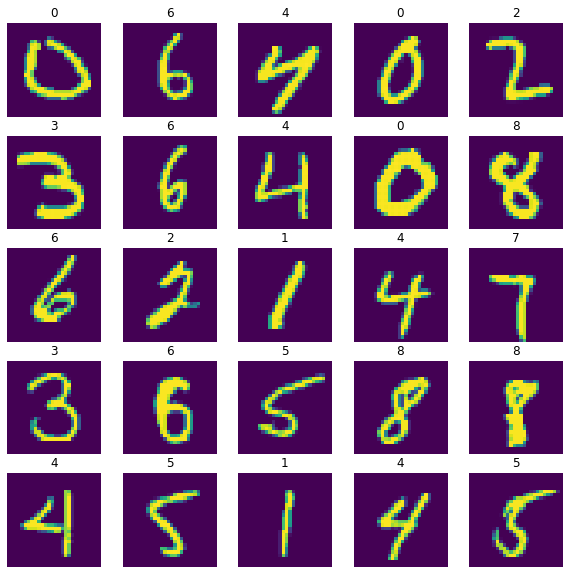

In [4]:
utils.visualize_dataset(TRAIN_MNIST, type(TRAIN_MNIST))

In [5]:
C, W, H = 1, 28, 28
NUM_CLASSES = 10
LEARNING_RATE = 1e-2
MOMENTUM = 0.9
LOSS_FN = F.mse_loss
PRINT_EVERY = 1000
EPOCHS = 5

In [6]:
class Vanilla_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden=10):
        super(Vanilla_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, hidden)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_size)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [7]:
Vanilla_AE = Vanilla_Autoencoder(C*W*H).to(DEVICE)

Training for 5 epochs
Checking accuracy on validation set
loss: 0.095


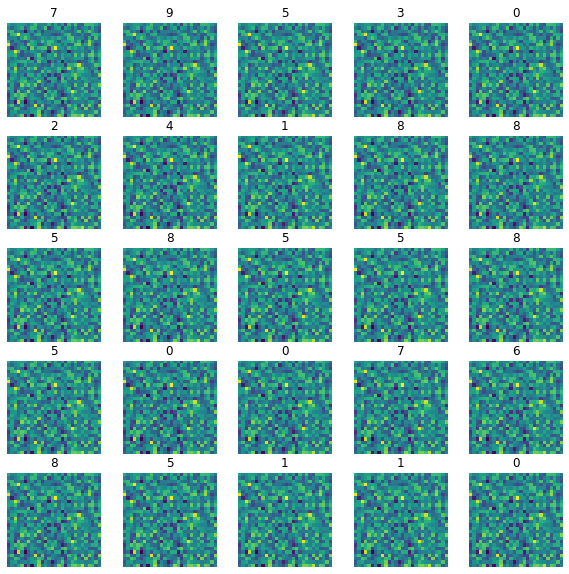


1 epochs completed...

Checking accuracy on validation set
loss: 0.057


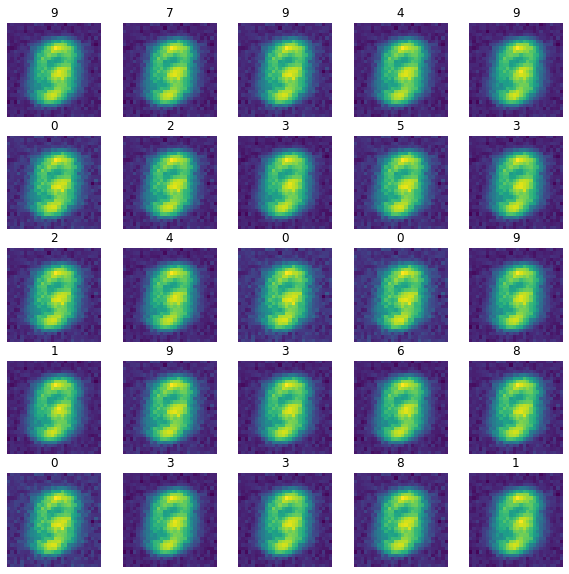


2 epochs completed...

Checking accuracy on validation set
loss: 0.064


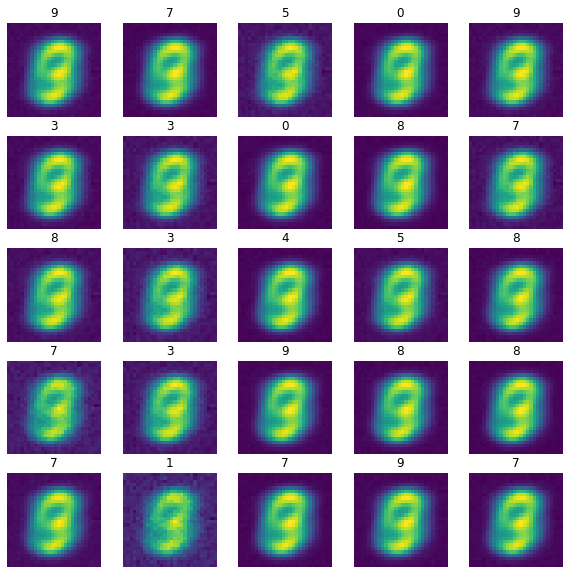


3 epochs completed...

Checking accuracy on validation set
loss: 0.069


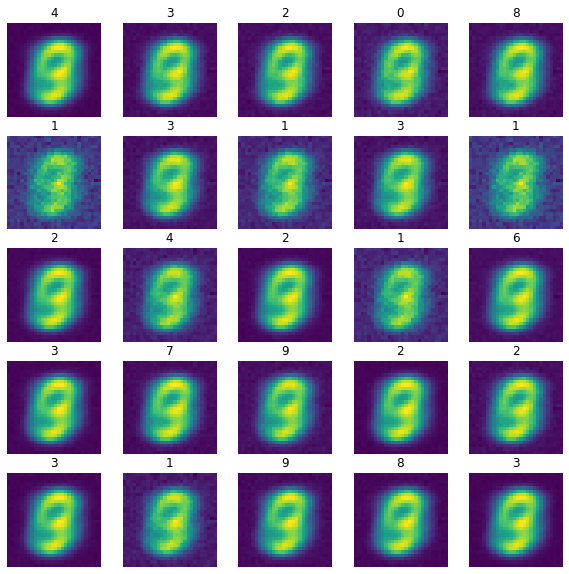


4 epochs completed...

Checking accuracy on validation set
loss: 0.071


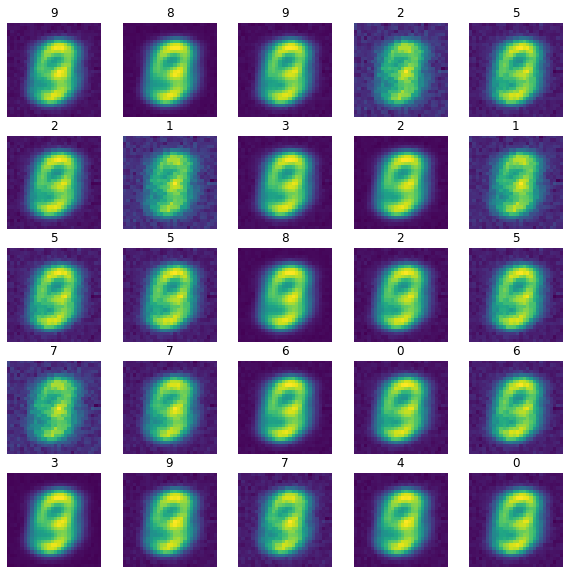


5 epochs completed...



In [8]:
optimizer = optim.SGD(Vanilla_AE.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, nesterov=True)
AE.train(Vanilla_AE, optimizer, loader_TRAIN, loader_VAL, 
         loss_fn=LOSS_FN, flatten_data=True, 
         print_every=PRINT_EVERY,
         device=DEVICE, epochs=EPOCHS)